# Plotting Maps

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from contextily import Place
import contextily as cx
from matplotlib.patches import Rectangle

import folium

import pickle


In [77]:
def filter_zero(dict):
    result = {key: value for key, value in dict.items() if abs(value) > 1e-5}
    return result

In [78]:
DATA_PATH = '../data'
RESULTS_PATH = os.path.join(DATA_PATH, 'results')
PRICES_PATH = os.path.join(DATA_PATH, 'prices')
SIMULATION_DATA_PATH = os.path.join(DATA_PATH, 'simulation data')
prices = pd.read_csv(os.path.join(PRICES_PATH, 'Spain_prices.csv'))

In [79]:
# load data
with open(os.path.join(RESULTS_PATH, 'extremes.csv'), 'rb') as f:
    dict_extremes = pickle.load(f)

df_locations = pd.read_csv(os.path.join(RESULTS_PATH, 'all_locations.csv'))

## Process data

In [80]:
#df_locations

df_locations['lat'] = df_locations['lat_lon'].str.split('_').str[0]
df_locations['lon'] = df_locations['lat_lon'].str.split('_').str[1]
gdf_all = gpd.GeoDataFrame(df_locations, geometry=gpd.points_from_xy(df_locations.lon, df_locations.lat), crs="EPSG:4326"
)
gdf_all = gdf_all.to_crs(epsg=3857)

In [82]:
# TODO: clean dictionary of extreme points (remember also boundary point). MAKE SO WE GET A DICTIONARY OF DATA FRAMES OUT THAT WE CAN PLOT EASELY

locations = pd.DataFrame({'lat_lon': production['lat_lon'].unique()})
locations['lat'] = locations['lat_lon'].str.split('_').str[0]
locations['lon'] = locations['lat_lon'].str.split('_').str[1]
#gdf_all = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.lon, locations.lat), crs="EPSG:4326")
#gdf_all = gdf_all.to_crs(epsg=3857)

locations = pd.DataFrame({'lat_lon': filter_zero(extreme_w[0]).keys()})
locations['lat'] = locations['lat_lon'].str.split('_').str[0]
locations['lon'] = locations['lat_lon'].str.split('_').str[1]
gdf_min_var = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.lon, locations.lat), crs="EPSG:4326"
)
gdf_min_var = gdf_min_var.to_crs(epsg=3857)

In [83]:
gdf_min_var['weight'] = pd.Series(filter_zero(extreme_w[0]).values())
gdf_min_var

lat_lon      lat      lon                         geometry  \
0  37.5021_-4.4298  37.5021  -4.4298   POINT (-493123.08 4509326.059)   
1   41.6591_0.8423  41.6591   0.8423    POINT (93764.407 5110050.276)   
2  42.4587_-8.3965  42.4587  -8.3965  POINT (-934694.104 5229940.068)   
3  42.9692_-1.9821  42.9692  -1.9821  POINT (-220646.363 5307284.947)   

     weight  
0  0.444617  
1  0.240730  
2  0.259943  
3  0.054709

In [84]:
extreme_w[0].keys()

dict_keys(['37.3467_-5.6815', '37.5021_-4.4298', '37.6571_-2.4870', '38.3250_-3.2432', '38.4885_-5.0687', '38.5089_-1.1831', '38.7432_-6.7377', '40.2523_-1.9654', '40.3220_-0.1269', '40.3617_-4.5602', '40.5403_-6.2422', '41.3479_1.0205', '41.5629_-5.7467', '41.5727_-1.7437', '41.5824_-3.7648', '41.6591_0.8423', '42.4587_-8.3965', '42.9692_-1.9821', '43.0932_-4.2335', '43.1742_-6.5667'])

## Plotting

In [85]:
base_layer = Place("Iberia", source=cx.providers.Esri.WorldShadedRelief, zoom=8)
FIGURES_PATH = '../figures'

def remove_link_text(ax):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    width = (xmax - xmin) * 0.2   # 20% of the x-axis width
    height = (ymax - ymin) * 0.1  # 10% of the y-axis height
    rectangle = Rectangle((xmin, ymin), width, height, color='#a0bcdc', zorder=100)
    ax.add_patch(rectangle)


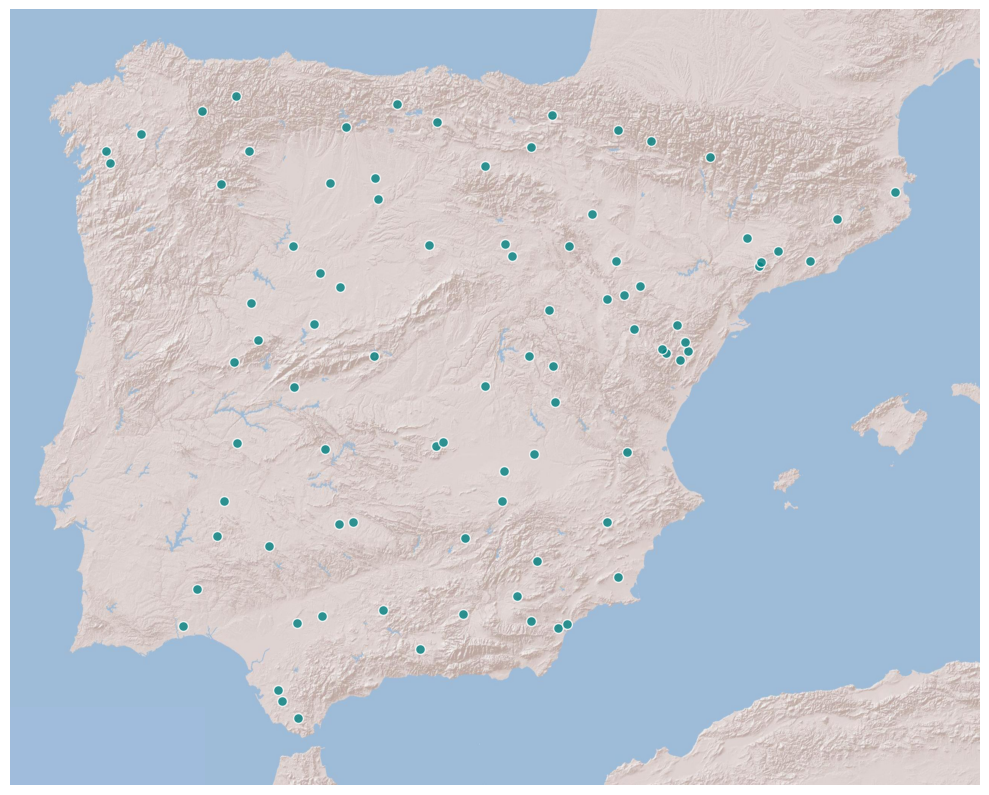

In [86]:
# All locations, no heatmap
fig, ax = plt.subplots(figsize=(10,10))

base_layer.plot(ax=ax)
gdf_all.plot(
    ax=ax,
    color='teal',          
    edgecolor='white',     
    marker='o',            
    alpha=0.8,             
    markersize=50,                       
)
remove_link_text(ax)

ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "all_locations.png"), dpi=300)

In [89]:
gdf_all['exp'].describe()

count        87.000000
mean     436720.150440
std       80984.418916
min      254115.987660
25%      379449.759480
50%      442494.579980
75%      497360.163400
max      606856.470260
Name: exp, dtype: float64

C:\Users\MathsCDT\AppData\Local\Temp\ipykernel_31924\4089033024.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


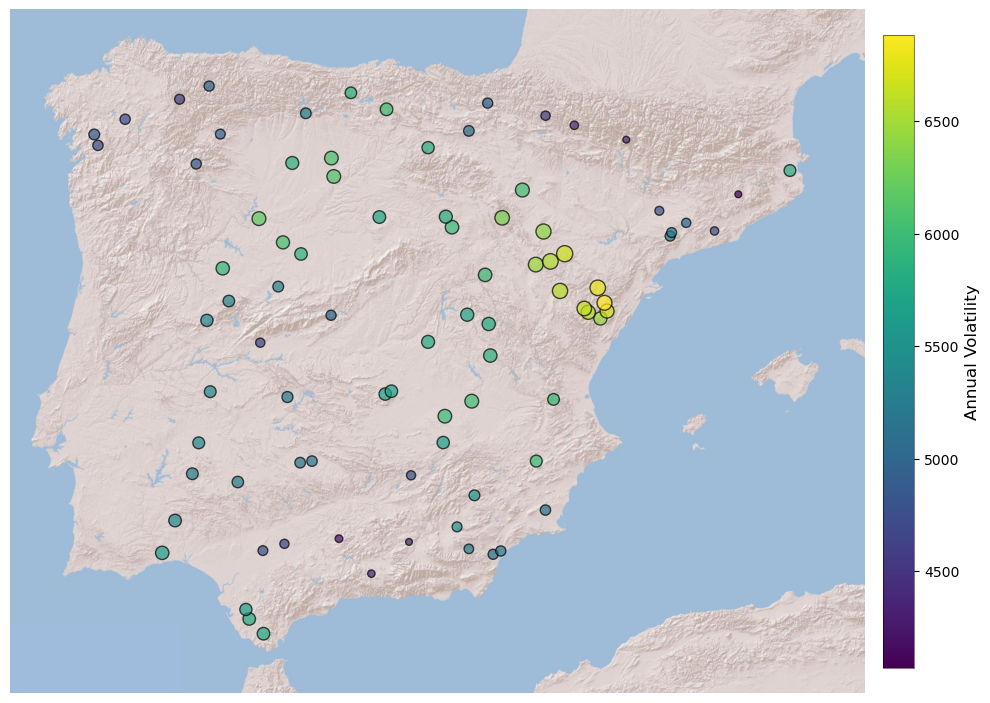

In [103]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot base layer
base_layer.plot(ax=ax)

# Normalize colors based on Volatility
norm = plt.Normalize(vmin=gdf_all['Volatility'].min(), vmax=gdf_all['Volatility'].max())
cmap = plt.cm.get_cmap('viridis')

# Plot points with mapped color and size
gdf_all.plot(
    ax=ax,
    color=gdf_all['Volatility'].map(lambda v: cmap(norm(v))),
    markersize=gdf_all['exp']**2 / gdf_all['exp'].mean()**2 * 70,
    marker='o',
    alpha=0.7,
    edgecolor='black'
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label('Annual Volatility', fontsize=12)
cbar.ax.tick_params(labelsize=10)
cbar.outline.set_alpha(0.5)
cbar.ax.set_facecolor((1, 1, 1, 0.6))  # semi-transparent white

# # Slightly lower the colorbar
# pos = cbar.ax.get_position()
# cbar.ax.set_position([pos.x0, pos.y0, pos.width, pos.height])

# Clean and show
remove_link_text(ax)
ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "all_locations.png"), dpi=300)
plt.show()


C:\Users\MathsCDT\AppData\Local\Temp\ipykernel_31924\4010591976.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis')


AttributeError: 'Axes' object has no attribute 'colorbar'

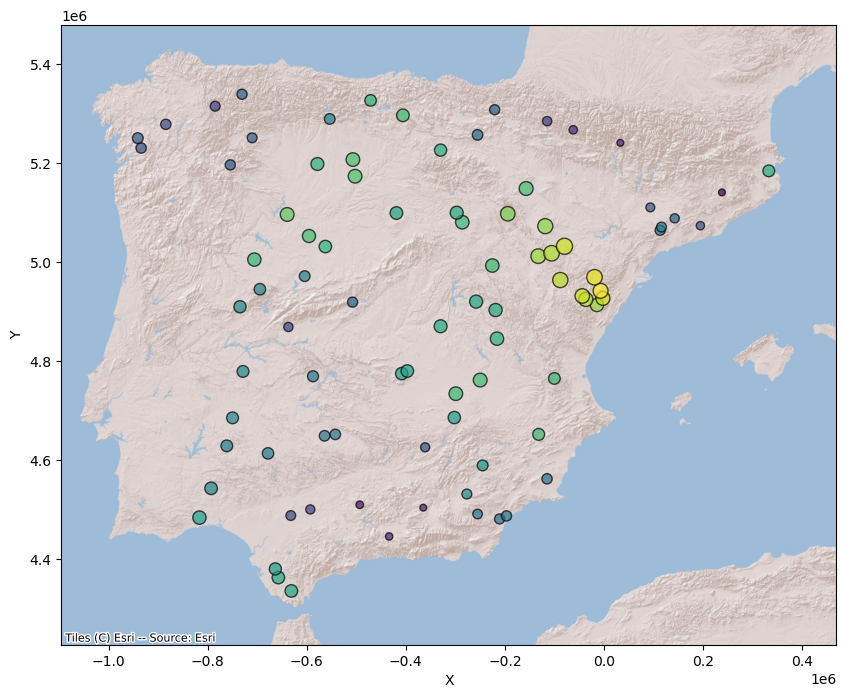

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot base layer
base_layer.plot(ax=ax)

# Normalize colors based on Volatility
norm = plt.Normalize(vmin=gdf_all['Volatility'].min(), vmax=gdf_all['Volatility'].max())
cmap = plt.cm.get_cmap('viridis')

# Plot points with mapped color and size
gdf_all.plot(
    ax=ax,
    color=gdf_all['Volatility'].map(lambda v: cmap(norm(v))),
    markersize=gdf_all['exp']**2 / gdf_all['exp'].mean()**2 * 70,
    marker='o',
    alpha=0.7,
    edgecolor='black'
)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02, location='right', anchor=(-0.5, 0.5))
cbar.set_label('Annual Volatility', fontsize=12)
cbar.ax.tick_params(labelsize=10)
cbar.outline.set_alpha(0.5)
cbar.ax.set_facecolor((1, 1, 1, 0.6))  # semi-transparent white

# # Slightly lower the colorbar
# pos = cbar.ax.get_position()
# cbar.ax.set_position([pos.x0, pos.y0, pos.width, pos.height])

# Clean and show
remove_link_text(ax)
ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "all_locations.png"), dpi=300)
plt.show()

In [ ]:
# min_var
fig, ax = plt.subplots(figsize=(10,10))

base_layer.plot(ax=ax)
gdf_all.plot(
    ax=ax,
    color='teal',          
    edgecolor='white',     
    marker='o',            
    alpha=0.8,             
    markersize=50,                       
)
remove_link_text(ax)

gdf_min_var.plot(
    ax=ax,
    color='teal',          
    edgecolor='white',     
    marker='o',            
    alpha=0.8,             
    markersize=50,                       
)

ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "min_var.png"), dpi=300)

In [ ]:
# Old: 
fig, ax = plt.subplots(figsize=(6, 6)) 


gdf = gdf.to_crs(epsg=3857)
# Plot your data
gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.7)

cx.add_basemap(
    ax,
    source=cx.providers.Esri.WorldShadedRelief,
    zoom=8
)

# Clean up plot
ax.set_axis_off()
ax.set_title("Spain Map with Terrain and Data Overlay", fontsize=14)

# Save as PNG
plt.savefig("spain_static_map.png", bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
spain_center = [40.0, -3.5]
m = folium.Map(location=spain_center, zoom_start=6, tiles=None)

# Add OpenTopoMap: terrain with hills and blue sea (free and no key needed)
folium.TileLayer(
    tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
    attr='Map data © OpenStreetMap contributors, SRTM | Map style: OpenTopoMap (CC-BY-SA)',
    name='OpenTopoMap',
    overlay=False,
    control=True
).add_to(m)

# Add your data on top
folium.GeoJson(gdf, name="Your Data").add_to(m)

folium.LayerControl().add_to(m)

m.save("spain_opentopo.html")
m

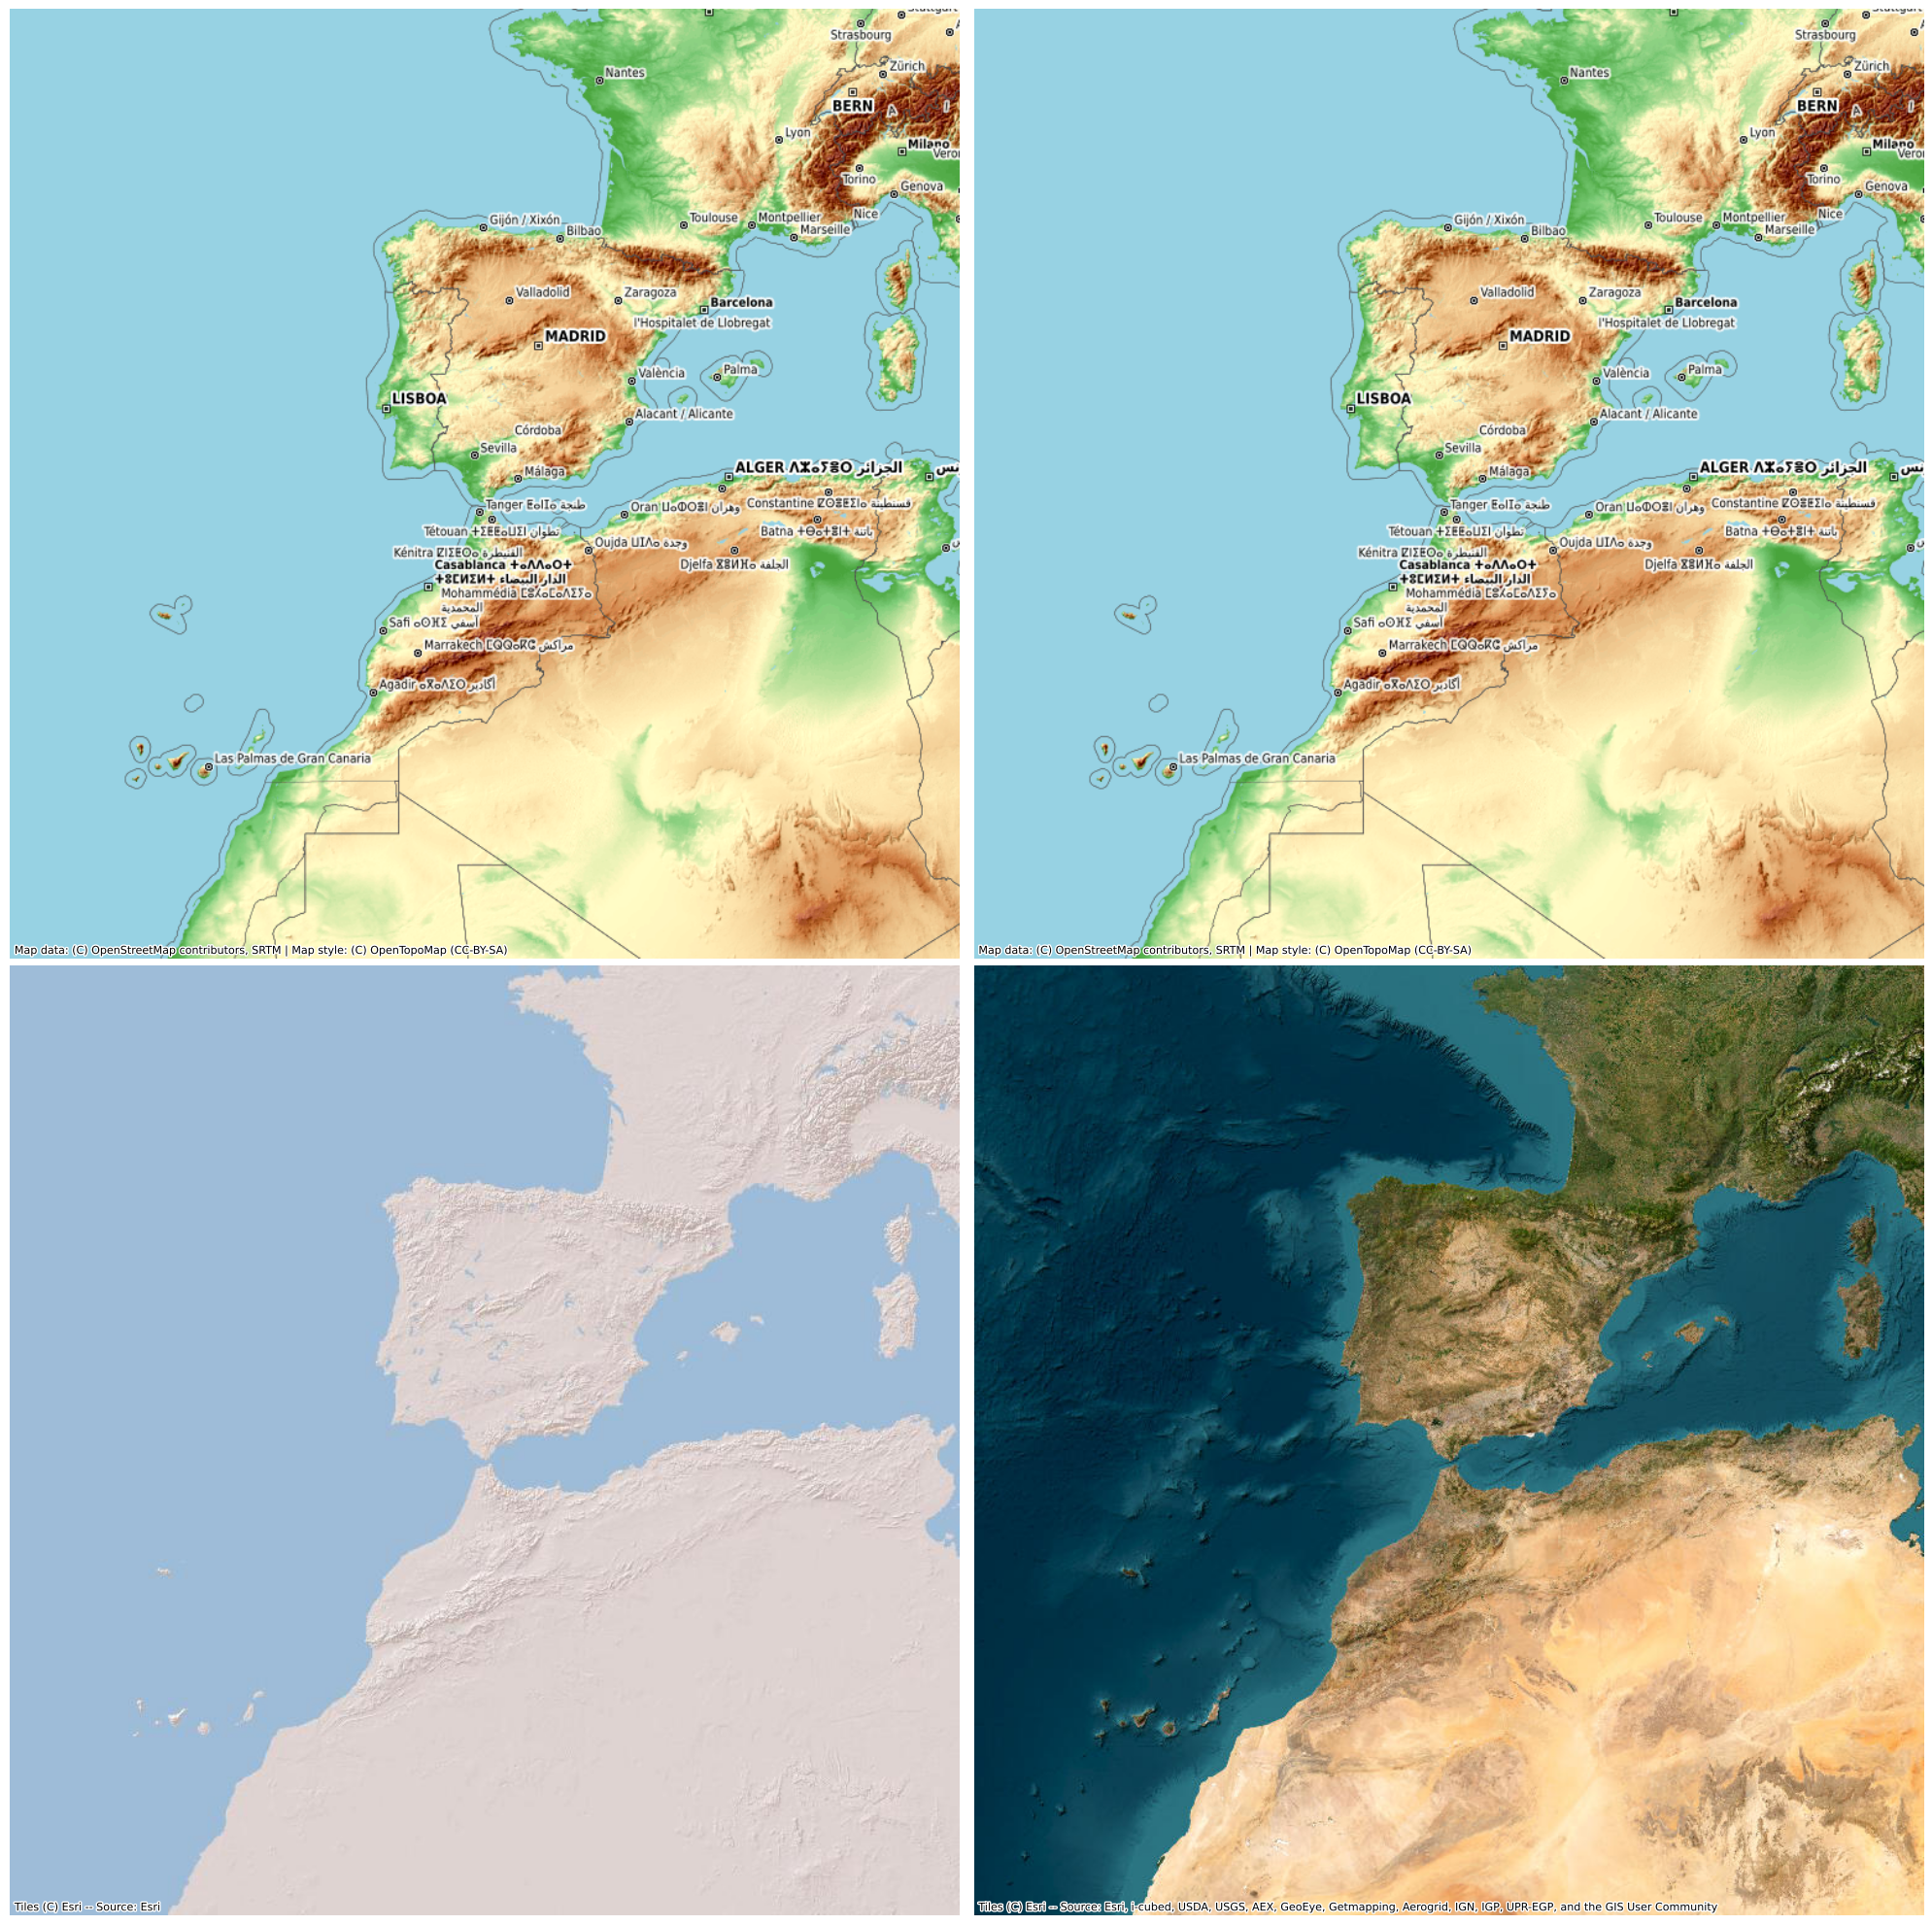

In [ ]:
# OLD: 
# fig, axs = plt.subplots(2,2, figsize=(20,20))
# terrain_providers = [
#     cx.providers.OpenTopoMap,
#     cx.providers.OpenTopoMap,
#     cx.providers.Esri.WorldShadedRelief,
#     cx.providers.Esri.WorldImagery
# ]
# for i, source in enumerate(terrain_providers):
#     ax = Place("Spain", source=source).plot(ax=axs.flatten()[i])
#     ax.axis("off")
#     plt.tight_layout()

In [ ]:
extreme_w = [{'37.3467_-5.6815': 0.0,
  '37.5021_-4.4298': 0.4446174671933166,
  '37.6571_-2.4870': 0.0,
  '38.3250_-3.2432': 0.0,
  '38.4885_-5.0687': 0.0,
  '38.5089_-1.1831': 0.0,
  '38.7432_-6.7377': 0.0,
  '40.2523_-1.9654': 0.0,
  '40.3220_-0.1269': 0.0,
  '40.3617_-4.5602': 0.0,
  '40.5403_-6.2422': 0.0,
  '41.3479_1.0205': 0.0,
  '41.5629_-5.7467': 0.0,
  '41.5727_-1.7437': 0.0,
  '41.5824_-3.7648': 0.0,
  '41.6591_0.8423': 0.240730443887266,
  '42.4587_-8.3965': 0.2599428641897448,
  '42.9692_-1.9821': 0.0547092247296728,
  '43.0932_-4.2335': 0.0,
  '43.1742_-6.5667': 0.0},
 {'37.3467_-5.6815': 0.0982742555075485,
  '37.5021_-4.4298': 0.0,
  '37.6571_-2.4870': 0.0,
  '38.3250_-3.2432': 0.0,
  '38.4885_-5.0687': 0.0,
  '38.5089_-1.1831': 0.0,
  '38.7432_-6.7377': 0.166384179115139,
  '40.2523_-1.9654': 0.0510282287489681,
  '40.3220_-0.1269': 0.1445065058804274,
  '40.3617_-4.5602': 0.0,
  '40.5403_-6.2422': 0.0,
  '41.3479_1.0205': 0.0470048785665864,
  '41.5629_-5.7467': 0.0034439005583212,
  '41.5727_-1.7437': 0.0953879572968595,
  '41.5824_-3.7648': 0.0,
  '41.6591_0.8423': 0.0,
  '42.4587_-8.3965': 0.3059253253084997,
  '42.9692_-1.9821': 0.0880447690176501,
  '43.0932_-4.2335': 0.0,
  '43.1742_-6.5667': 0.0},
 {'37.3467_-5.6815': 0.0,
  '37.5021_-4.4298': 0.0,
  '37.6571_-2.4870': 0.0,
  '38.3250_-3.2432': 0.0,
  '38.4885_-5.0687': 0.0,
  '38.5089_-1.1831': 0.0,
  '38.7432_-6.7377': 0.0,
  '40.2523_-1.9654': 0.0,
  '40.3220_-0.1269': 0.0,
  '40.3617_-4.5602': 0.0,
  '40.5403_-6.2422': 0.0,
  '41.3479_1.0205': 0.0,
  '41.5629_-5.7467': 0.0,
  '41.5727_-1.7437': 1.0,
  '41.5824_-3.7648': 0.0,
  '41.6591_0.8423': 0.0,
  '42.4587_-8.3965': 0.0,
  '42.9692_-1.9821': 0.0,
  '43.0932_-4.2335': 0.0,
  '43.1742_-6.5667': 0.0}]

In [ ]:
# All locations heatmap

fig, ax = plt.subplots(figsize=(10,10))

base_layer.plot(ax=ax)
gdf_all.plot(
    ax=ax,
    column='Volatility',       # color by 'Volatility'
    markersize=gdf_all['exp']**2 / gdf_all['exp'].mean()**2 * 70,  # size by 'exp'
    cmap='viridis',            # or e.g. 'plasma', 'coolwarm'
    marker='o', 
    legend=True,
    alpha=0.7,
    edgecolor='black'
)

remove_link_text(ax)


ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, "all_locations.png"), dpi=300)